In [1]:
class Config:
  DATASET_PATH = "data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  UCSD_DATASET_PATHS = ["data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train", "data/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train"]
  AVENUE_DATASET_PATH = "data/Avenue_Dataset/training_videos"
  SINGLE_TEST_PATH = "data/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test002"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "UCSD+Avenue_model_lstm.hdf5"

In [2]:
###IMPORTS AND DEPENDENCIES####

import tensorflow
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt

In [8]:

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 128 x 128
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    #all_training = [f for path in Config.DATASET_PATH for f in sorted(listdir(path))]
    all_training_paths = Config.UCSD_DATASET_PATHS
    all_training_paths.append(Config.AVENUE_DATASET_PATH)
    count = 0
    for data_file in all_training_paths:
        for f in sorted(listdir(data_file)):
            if isdir(join(data_file, f)):
                all_frames = []
                # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
                for c in sorted(listdir(join(data_file, f))):
                    if count: 
                        count = 0
                        continue
                    if str(join(join(data_file, f), c))[-3:] == "tif":
                        img = Image.open(join(join(data_file, f), c)).resize((256, 256))
                    elif str(join(join(data_file, f), c))[-3:] == "png":
                        img = Image.open(join(join(data_file, f), c)).resize((256, 256)).convert('L')
                    else: continue
                    #print(join(join(data_file, f), c))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
                    count = 1
                # get the 10-frames sequences from the list of images after applying data augmentation
                for stride in range(1, 3):
                    clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips
    

In [9]:

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    tensorflow.keras.backend.set_floatx('float32')
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer = Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    #seq.compile(loss='mse')
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [10]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test


In [11]:

def evaluate():
    model = get_model(True)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    
    # Reconstruction of the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=Config.BATCH_SIZE)
    print(reconstructed_sequences)
    #Sequences Reconstruction Cost e(x,y,sz)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization (LayerNo (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 32)    1

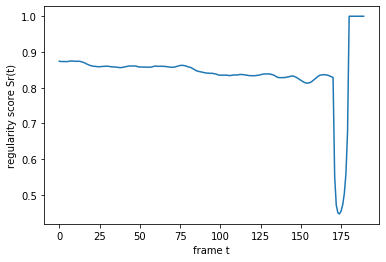

In [12]:
evaluate()
